# Import dataset and a bit of data visualization

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

data = pd.read_csv('../data/creditcard.csv')
print(data.shape)
#data = data.iloc[:1000,:]

(284807, 31)


### Structure of the two classes 

Text(0, 0.5, 'Third component')

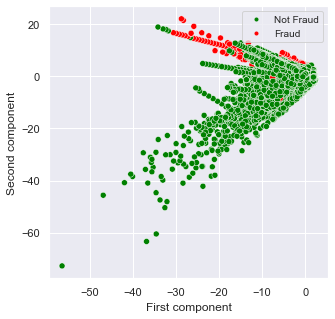

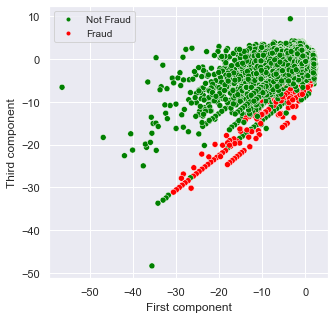

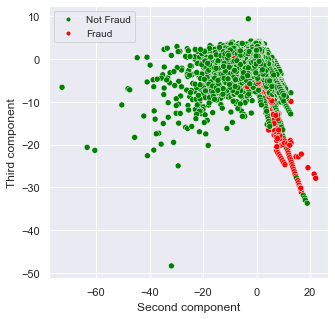

In [2]:
sns.set_theme()
sizeplots = (5,5)
sizelegend = 10
##########################################
#First Plot
plt.figure(figsize=sizeplots)

plot = sns.scatterplot(x = data["V1"],
                y = data["V2"],
                hue = data["Class"],
                palette = ["green", "red"],
                legend = False)

custom = [Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='red', linestyle='None')]
plt.legend(custom, ["Not Fraud", "Fraud"], prop={'size': sizelegend})
plt.xlabel("First component")
plt.ylabel("Second component")

##########################################
#Second Plot
plt.figure(figsize=sizeplots)

sns.scatterplot(x = data["V1"],
                y = data["V3"],
                hue = data["Class"],
                palette = ["green", "red"],
                legend = False)

custom = [Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='red', linestyle='None')]
plt.legend(custom, ["Not Fraud", "Fraud"], prop={'size': sizelegend})
plt.xlabel("First component")
plt.ylabel("Third component")

##########################################
#Third Plot
plt.figure(figsize=sizeplots)

sns.scatterplot(x = data["V2"],
                y = data["V3"],
                hue = data["Class"],
                palette = ["green", "red"],
                legend = False)

custom = [Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='red', linestyle='None')]
plt.legend(custom, ["Not Fraud", "Fraud"], prop={'size': sizelegend})
plt.xlabel("Second component")
plt.ylabel("Third component")

It seems that there are some patterns in the frauds, but must be considered that the dataset is higly unbalaced

## Data preparation

In [3]:
X = data.iloc[:,:-1]
y = data["Class"]
print("The features are: {}".format(list(X.columns)))
print("The variable of interest is: {}".format(y.name))

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("Number of samples of train set: {}".format(len(y_train)))
print("Number of samples of test set: {}".format(len(y_test)))

The features are: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
The variable of interest is: Class
Number of samples of train set: 199364
Number of samples of test set: 85443


# Tree based models

## Decision tree

### Tree with sklearn's default tuning parameter -  Full tree

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

dt_default = DecisionTreeClassifier(random_state = 0) #uses gini impurity instead of entropy
dt_default.fit(X_train, y_train)
y_pred = dt_default.predict(X_test)

Text(21.499999999999996, 0.5, 'True label')

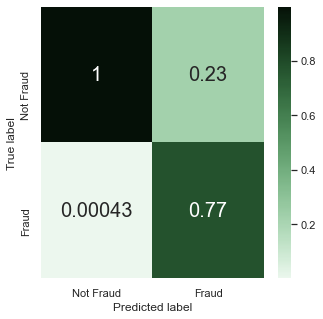

In [5]:
sizeplots = (5,5)
plt.figure(figsize=sizeplots)

cm = confusion_matrix(y_test, y_pred)
cm_marginal = cm/cm.sum(axis=0)

sns.heatmap(cm_marginal,
            annot=True,
            annot_kws={"size": 20},
            cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted label")
plt.ylabel("True label")

The default decision tree classifies correctly almost all the non fraudolent transactions, and the 77% of the fraudolent ones. (Note that the proportions are done by column, and represent the conditional distribution of the true labels given the prediction)

### Tree with tuning parameters optimization - Pruned tree

In [6]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

#Extract a portion of the train set for evaluating the best hyperparameters configuration
#using directly the test set would be unfair! B
#This because we will compare, in order to find the best model, all the models and using here the test 
#wound give an unfair advantage to this model
X_train_little, X_val, y_train_little, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)

dt = DecisionTreeClassifier(random_state = 0)

param_grid = ParameterGrid({
    'max_depth': np.arange(5, 32,4),
    'min_samples_leaf': 2 ** np.arange(5),
    "min_impurity_decrease": 10 ** np.arange(-5,-3,0.5)
})

results = []

for params in tqdm(param_grid):
    dt.set_params(**params)
    dt.fit(X_train_little, y_train_little)
    y_pred = dt.predict(X_val)
    params["f1_score"] = f1_score(y_val, y_pred)
    results.append(params)
    
results = pd.DataFrame(results)

#we want the model with the best f1score, in case of tie we choose the more parsimonious (Occam's razor)
results = results.sort_values(["f1_score","max_depth","min_impurity_decrease","min_samples_leaf"],                                        ascending = [False,True,False,False])
results.head(10)

,max_depth,min_impurity_decrease,min_samples_leaf,f1_score
21,9,0.00001,2,0.837736
20,9,0.00001,1,0.837736
41,13,0.00001,2,0.837736
40,13,0.00001,1,0.837736
61,17,0.00001,2,0.837736
60,17,0.00001,1,0.837736
81,21,0.00001,2,0.837736
80,21,0.00001,1,0.837736
101,25,0.00001,2,0.837736
100,25,0.00001,1,0.837736


Text(21.499999999999996, 0.5, 'True label')

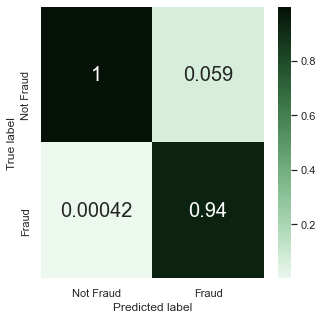

In [7]:
sizeplots = (5,5)
plt.figure(figsize=sizeplots)

best_params = param_grid[results.index[0]]
dt.set_params(**best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_marginal = cm/cm.sum(axis=0)

sns.heatmap(cm_marginal,
            annot=True,
            annot_kws={"size": 20},
            cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted label")
plt.ylabel("True label")

The optimazed tree performs better than the default one, maintaining almost all the not fradolent guesses correct, and increasing the amount of instances correctly classified as frauds up to 94%

## Random forest

### Trees bult on bootstrap replications with default parameters

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_default = RandomForestClassifier(n_estimators=10, random_state = 0, bootstrap = True)
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_test)

Text(21.499999999999996, 0.5, 'True label')

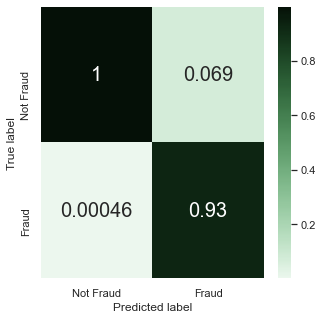

In [21]:
sizeplots = (5,5)
plt.figure(figsize=sizeplots)

cm = confusion_matrix(y_test, y_pred)
cm_marginal = cm/cm.sum(axis=0)

sns.heatmap(cm_marginal,
            annot=True,
            annot_kws={"size": 20},
            cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted label")
plt.ylabel("True label")

### Trees bult on bootstrap replications with optimal parameters
The ones that we found before during the tuning of the pruning tree

In [24]:
rf_optimized = RandomForestClassifier(n_estimators=100, random_state = 0, bootstrap = True)
rf_optimized.set_params(**best_params)
rf_optimized.fit(X_train, y_train)
y_pred = rf_optimized.predict(X_test)

Text(21.499999999999996, 0.5, 'True label')

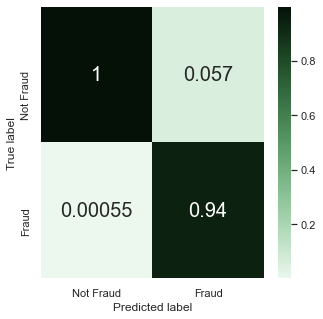

In [25]:
sizeplots = (5,5)
plt.figure(figsize=sizeplots)

cm = confusion_matrix(y_test, y_pred)
cm_marginal = cm/cm.sum(axis=0)

sns.heatmap(cm_marginal,
            annot=True,
            annot_kws={"size": 20},
            cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted label")
plt.ylabel("True label")

Random forest didn't improve the performance, probably because there are only few fraudolent observation and they can't reach the same outliers

In [10]:
import dill
dill.load_session('massimiliano_notebook_env.db')

In [11]:
import dill
dill.dump_session('massimiliano_notebook_env.db')